In [1]:
import os
import random
import cv2
import zipfile
import shutil
import numpy as np
from tqdm import tqdm
import albumentations as A

# --- SEEDING FOR REPRODUCIBILITY ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# --- CONFIGURATION ---
SOURCE_DIR = "/kaggle/input/diabetic-retinopathy-resized-arranged"
TARGET_DIR = "balanced_dataset"
CLASSES = ['0', '1', '2', '3', '4']

TARGET_COUNTS = {
    '0': 5000, '1': 2443, '2': 5000, '3': 2500, '4': 2500
}

# --- MEDICAL AUGMENTATION PIPELINE ---
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.OneOf([
        A.CLAHE(clip_limit=2.0, p=0.5),
        A.Sharpen(p=0.5),
    ], p=0.3),
    A.RandomBrightnessContrast(p=0.2),
])

def process_classes():
    if os.path.exists(TARGET_DIR):
        shutil.rmtree(TARGET_DIR) # Clean start
    os.makedirs(TARGET_DIR, exist_ok=True)
    
    for cls in CLASSES:
        cls_path = os.path.join(SOURCE_DIR, cls)
        save_path = os.path.join(TARGET_DIR, cls)
        os.makedirs(save_path, exist_ok=True)
        
        images = os.listdir(cls_path)
        target = TARGET_COUNTS[cls]
        
        print(f"Processing Class {cls}...")
        
        # 1. DOWNSAMPLING or KEEPING
        if len(images) >= target:
            selected = random.sample(images, target)
            for img_name in tqdm(selected):
                img = cv2.imread(os.path.join(cls_path, img_name))
                cv2.imwrite(os.path.join(save_path, img_name), img)
        
        # 2. OVERSAMPLING via AUGMENTATION
        else:
            for img_name in images:
                img = cv2.imread(os.path.join(cls_path, img_name))
                cv2.imwrite(os.path.join(save_path, img_name), img)
            
            num_to_augment = target - len(images)
            for i in tqdm(range(num_to_augment)):
                orig_name = random.choice(images)
                img = cv2.imread(os.path.join(cls_path, orig_name))
                augmented = augmentor(image=img)['image']
                cv2.imwrite(os.path.join(save_path, f"aug_{i}_{orig_name}"), augmented)

# Run processing
process_classes()

# --- NEW: SAVE AS ZIP ---
print("Zipping dataset for future use...")
shutil.make_archive('DR_Balanced_Dataset_Final', 'zip', TARGET_DIR)
print("Done! File saved as: DR_Balanced_Dataset_Final.zip")

Processing Class 0...


100%|██████████| 5000/5000 [01:35<00:00, 52.23it/s]


Processing Class 1...


100%|██████████| 2443/2443 [00:49<00:00, 49.71it/s]


Processing Class 2...


100%|██████████| 5000/5000 [01:24<00:00, 59.33it/s]


Processing Class 3...


100%|██████████| 1627/1627 [00:26<00:00, 60.58it/s]


Processing Class 4...


100%|██████████| 1792/1792 [00:29<00:00, 61.64it/s]


Zipping dataset for future use...
Done! File saved as: DR_Balanced_Dataset_Final.zip


In [2]:
from IPython.display import FileLink
FileLink(r'DR_Balanced_Dataset_Final.zip')

/kaggle/working/DR_Balanced_Dataset_Final.zip

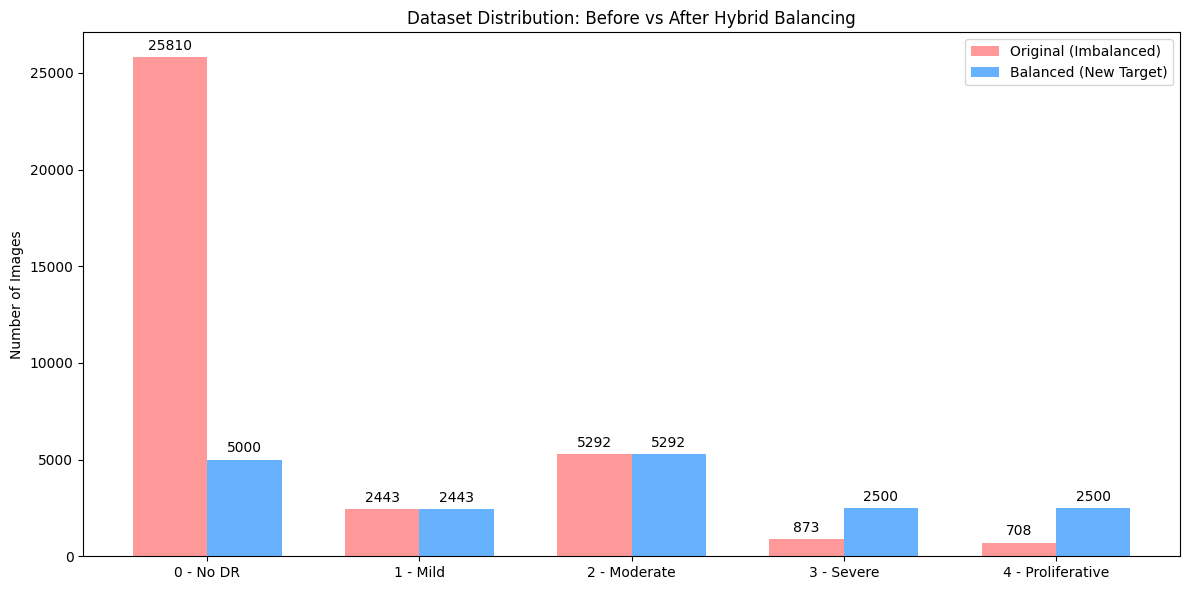

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Original Data (from your counts)
data = {
    'Class': ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative'],
    'Original': [25810, 2443, 5292, 873, 708],
    'Strategy': ['Downsample to 5k', 'Keep All', 'Keep All', 'Augment to 2.5k', 'Augment to 2.5k']
}

df = pd.DataFrame(data)

# Calculated Balanced Counts
df['Balanced'] = [5000, 2443, 5292, 2500, 2500]

# --- PLOTTING ---
x = np.arange(len(df['Class']))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, df['Original'], width, label='Original (Imbalanced)', color='#FF9999')
rects2 = ax.bar(x + width/2, df['Balanced'], width, label='Balanced (New Target)', color='#66B2FF')

# Add text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Images')
ax.set_title('Dataset Distribution: Before vs After Hybrid Balancing')
ax.set_xticks(x)
ax.set_xticklabels(df['Class'])
ax.legend()

# Label each bar with its count
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.tight_layout()
plt.show()

In [4]:
import os
import random
import cv2
import zipfile
import shutil
import numpy as np
from tqdm import tqdm
import albumentations as A
from PIL import Image

# --- CONFIGURATION ---
IMG_SIZE = 640  # We bake this resolution into the saved files
SOURCE_DIR = "/kaggle/input/diabetic-retinopathy-resized-arranged"
TARGET_DIR = "processed_balanced_640px" # New name to avoid confusion
CLASSES = ['0', '1', '2', '3', '4']

TARGET_COUNTS = {'0': 5000, '1': 2443, '2': 5000, '3': 2500, '4': 2500}

# --- BEN GRAHAM FUNCTION (Internal) ---
def apply_ben_graham(img, size=IMG_SIZE):
    # img is already an OpenCV BGR image here
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Auto-crop black borders
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask = gray > 10
    if image[np.ix_(mask.any(1), mask.any(0))].size > 0:
        image = image[np.ix_(mask.any(1), mask.any(0))]
        
    image = cv2.resize(image, (size, size))
    # Gaussian subtraction for lesion contrast
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), size/30), -4, 128)
    # Return BGR for cv2.imwrite
    return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

def process_classes():
    if os.path.exists(TARGET_DIR):
        shutil.rmtree(TARGET_DIR)
    os.makedirs(TARGET_DIR, exist_ok=True)
    
    for cls in CLASSES:
        cls_path = os.path.join(SOURCE_DIR, cls)
        save_path = os.path.join(TARGET_DIR, cls)
        os.makedirs(save_path, exist_ok=True)
        
        images = os.listdir(cls_path)
        target = TARGET_COUNTS[cls]
        print(f"Processing & Pre-processing Class {cls}...")
        
        # 1. DOWNSAMPLING / KEEPING
        if len(images) >= target:
            selected = random.sample(images, target)
            for img_name in tqdm(selected):
                img = cv2.imread(os.path.join(cls_path, img_name))
                processed_img = apply_ben_graham(img) # <--- PRE-PROCESS HERE
                cv2.imwrite(os.path.join(save_path, img_name), processed_img)
        
        # 2. OVERSAMPLING via AUGMENTATION
        else:
            # First, process original images
            for img_name in images:
                img = cv2.imread(os.path.join(cls_path, img_name))
                processed_img = apply_ben_graham(img)
                cv2.imwrite(os.path.join(save_path, img_name), processed_img)
            
            # Then create augmented versions
            num_to_augment = target - len(images)
            for i in tqdm(range(num_to_augment)):
                orig_name = random.choice(images)
                img = cv2.imread(os.path.join(cls_path, orig_name))
                # Augment first, THEN apply Ben Graham
                augmented = augmentor(image=img)['image']
                processed_aug = apply_ben_graham(augmented) # <--- PRE-PROCESS HERE
                cv2.imwrite(os.path.join(save_path, f"aug_{i}_{orig_name}"), processed_aug)

# Run it
process_classes()

# Zip the "Ready-to-Train" images
shutil.make_archive('DR_Ready_For_GPU', 'zip', TARGET_DIR)
print("Done! File saved as: DR_Ready_For_GPU.zip")

Processing & Pre-processing Class 0...


100%|██████████| 5000/5000 [10:25<00:00,  7.99it/s]


Processing & Pre-processing Class 1...


100%|██████████| 2443/2443 [04:52<00:00,  8.36it/s]


Processing & Pre-processing Class 2...


100%|██████████| 5000/5000 [09:55<00:00,  8.40it/s]


Processing & Pre-processing Class 3...


100%|██████████| 1627/1627 [03:33<00:00,  7.63it/s]


Processing & Pre-processing Class 4...


100%|██████████| 1792/1792 [03:49<00:00,  7.79it/s]


Done! File saved as: DR_Ready_For_GPU.zip


In [5]:
from IPython.display import FileLink
FileLink(r'DR_Ready_For_GPU.zip')

/kaggle/working/DR_Ready_For_GPU.zip